In [1]:
import sys; sys.path.insert(0, '..')
import utils
import keras
import numpy as np

def embed_and_translate(data, n_width, n_height):
    ndata = np.zeros((len(data), n_width, n_height, 1), dtype='float32')
    translations = np.empty((len(data), 2), dtype='float32')
    width, height = data.shape[1], data.shape[2]
    for i in range(len(data)):
        x = np.random.randint(n_width-width)
        y = np.random.randint(n_height-height)
        ndata[i][x:x+width, y:y+height] = data[i] # rows, cols = height, width
        translations[i][0] = x+(width//2)
        translations[i][1] = y+(height//2)
    return ndata, translations
            
n_splits = 16
output_shape = (56, 56, 1)
input_shape  = (14, 14, 1)
split_x, split_y = 14, 14
latent_dim = 196

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
x_train_augmented, y_train_regr = embed_and_translate(x_train, output_shape[0], output_shape[1])
x_train_split = np.array([utils.split(x, split_x, split_y) for x in x_train_augmented], dtype='float32')
y_train = keras.utils.to_categorical(y_train)

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
x_test_augmented, y_test_regr = embed_and_translate(x_test, output_shape[0], output_shape[1])
x_test_split = np.array([utils.split(x, split_x, split_y) for x in x_test_augmented], dtype='float32')
y_test = keras.utils.to_categorical(y_test)

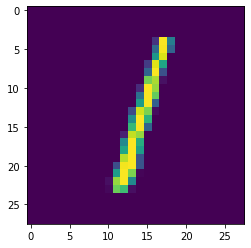

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

im = x_test_augmented[:32, :, :, :]
pos = y_test_regr[:32, :]

test = tf.image.extract_glimpse(im, (28, 28), pos, centered=False, normalized=False, noise='zero')
plt.imshow(tf.reshape(test[2], (28,28)))


In [3]:
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, concatenate, Activation, Dropout, MaxPooling2D
from keras import Sequential
from keras.models import Model

import tensorflow as tf
import keras
import sys; sys.path.insert(0, '..')
import utils

class MultiSplit(Model):
    def __init__(self, n_splits, latent_dim, input_shape, output_shape):
        super(MultiSplit, self).__init__()
        self.encoder = self._create_encoder(latent_dim, input_shape)
        self.input_reshaper = utils.Reshaper((n_splits, *input_shape), input_shape)
        self.latent_reshaper = utils.Reshaper([latent_dim], [n_splits * latent_dim])
        self.decoder = self._create_decoder(n_splits * latent_dim, output_shape)
        self.classifier = self._create_classifier(n_splits * latent_dim)
        self.regressor = self._create_regressor(n_splits * latent_dim)
        
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x)
#             y_pred['decoder_out'] = tf.image.extract_glimpse(y_pred['decoder_out'], (28,28), y['regressor_out'], centered=False, normalized=False, noise='zero')
            loss = self.compiled_loss(y, y_pred)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
        y_pred['decoder_out'] = tf.image.extract_glimpse(y_pred['decoder_out'], (28,28), y['regressor_out'], centered=False, normalized=False, noise='zero')
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def call(self, x, training=True):
        z = self.encode(x, training=training)
        y_regr = self.regress(z ,training=training)
        y_class = self.classify(z ,training=training)
        y_reco = self.decode(z ,training=training)
        return {"decoder_out": y_reco, "classifier_out": y_class, "regressor_out": y_regr}
        
    def encode(self, x, training=True):
        return self.encoder( self.input_reshaper(x) , training)
    
    def decode(self, z, training=True):
        return self.decoder( self.latent_reshaper(z) , training)
    
    def regress(self, z, training=True):
        return self.regressor( self.latent_reshaper(z) , training)
    
    def classify(self, z, training=True):
        return self.classifier( self.latent_reshaper(z) , training)
    
    def _create_encoder(self, latent_dim, input_shape, n_filters=[32,64]):
        return Sequential([
            Input(shape=input_shape),
            Conv2D(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Flatten(),
            Dense(units=latent_dim, activation='sigmoid')
        ], name='encoder')

    def _create_decoder(self, latent_dim, io_shape, n_filters=[32,64]):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(io_shape[0]//4 * io_shape[1]//4 * 8),  #! Reduce amount of neurons by 4.
            Reshape((io_shape[0]//4, io_shape[1]//4, 8)),
            Conv2DTranspose(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=1, kernel_size=(3,3), padding='same'),
            Activation('sigmoid', name='decoder_out')
        ])
    
    def _create_classifier(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(256, activation='relu'),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(10, activation='softmax', name='classifier_out')
        ])
    
    def _create_regressor(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(256, activation='relu'),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(10, activation='relu'),
            Dense(2, activation='linear', name='regressor_out')
        ])

In [ ]:
losses = {
    'decoder_out' : 'mse',
    'regressor_out' : 'mean_absolute_percentage_error'
}
loss_weights = {
    'decoder_out' : 1.0,
    'regressor_out' : 0.00
}
model = MultiSplit(n_splits, latent_dim, input_shape, output_shape)
opt = tf.keras.optimizers.Adam(
    learning_rate=0.1,
)
model.compile(loss=losses, loss_weights=loss_weights, optimizer=opt)


history = model.fit(x_train_split, {'decoder_out': x_train_augmented, 'regressor_out': y_train_regr},
                    validation_data=(x_test_split, {'decoder_out': x_test, 'regressor_out':y_test_regr}),
                    epochs=50, batch_size=32)

Epoch 1/50
1269/1875 [===================>..........] - ETA: 9s - loss: 0.0282 - decoder_out_loss: 0.0282 - regressor_out_loss: 99.0762

In [8]:
for latent_dim in [8,16]:
    import sys; sys.path.insert(0, '..')
    import utils
    import keras
    import numpy as np

    def embed_and_translate(data, n_width, n_height):
        ndata = np.zeros((len(data), n_width, n_height, 1), dtype='float32')
        translations = np.empty((len(data), 2), dtype='float32')
        width, height = data.shape[1], data.shape[2]
        for i in range(len(data)):
            x = np.random.randint(n_width-width)
            y = np.random.randint(n_height-height)
            ndata[i][x:x+width, y:y+height] = data[i] # rows, cols = height, width
            translations[i][0] = x+(width//2)
            translations[i][1] = y+(height//2)
        return ndata, translations

    n_splits = 16
    output_shape = (56, 56, 1)
    input_shape  = (14, 14, 1)
    split_x, split_y = 14, 14
#     latent_dim = 1

    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
    x_train = x_train.astype('float32') / 255.
    x_train_augmented, y_train_regr = embed_and_translate(x_train, output_shape[0], output_shape[1])
    x_train_split = np.array([utils.split(x, split_x, split_y) for x in x_train_augmented], dtype='float32')
    y_train = keras.utils.to_categorical(y_train)

    x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
    x_test = x_test.astype('float32') / 255.
    x_test_augmented, y_test_regr = embed_and_translate(x_test, output_shape[0], output_shape[1])
    x_test_split = np.array([utils.split(x, split_x, split_y) for x in x_test_augmented], dtype='float32')
    y_test = keras.utils.to_categorical(y_test)
    
    losses = {
    'decoder_out' : 'mse',
    'regressor_out' : 'mean_absolute_percentage_error'
    }
    loss_weights = {
        'decoder_out' : 1.0,
        'regressor_out' : 0.00
    }
    model = MultiSplit(n_splits, latent_dim, input_shape, output_shape)
    model.compile(loss=losses, loss_weights=loss_weights, optimizer='adam')

    history = model.fit(x_train_split, {'decoder_out': x_train_augmented, 'regressor_out': y_train_regr},
                        validation_data=(x_test_split, {'decoder_out': x_test, 'regressor_out':y_test_regr}),
                        epochs=50, batch_size=32)
    
    model = None
    x_test, x_train = None, None
    x_train_augmented, y_train_regr = None, None
    x_test_augmented, y_test_regr = None, None
    y_train, y_test = None, None

Epoch 1/50
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0169 - decoder_out_loss: 0.0169 - regressor_out_loss: 100.8204 - val_loss: 0.0266 - val_decoder_out_loss: 0.0266 - val_regressor_out_loss: 100.4433
Epoch 2/50
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0057 - decoder_out_loss: 0.0057 - regressor_out_loss: 100.4536 - val_loss: 0.0205 - val_decoder_out_loss: 0.0205 - val_regressor_out_loss: 100.4644
Epoch 3/50
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0049 - decoder_out_loss: 0.0049 - regressor_out_loss: 100.4587 - val_loss: 0.0182 - val_decoder_out_loss: 0.0182 - val_regressor_out_loss: 100.4595
Epoch 4/50
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0045 - decoder_out_loss: 0.0045 - regressor_out_loss: 100.4569 - val_loss: 0.0171 - val_decoder_out_loss: 0.0171 - val_regressor_out_loss: 100.4542
Epoch 5/50
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0041 - d

In [3]:
model = None
model = MultiSplit(n_splits, latent_dim, input_shape, output_shape)
# model.load_weights('../weights/43_CAE4x16_regr+class_epoch50_weights.h5')

losses = {
    'decoder_out' : 'mse',
    'regressor_out' : 'mean_absolute_percentage_error',
    'classifier_out' : 'categorical_crossentropy'
}
loss_weights = {
    'decoder_out' : 1.0,
    'regressor_out' : 0.1,
    'classifier_out' : 0.05
}

# model.encoder.load_weights(ew)
# for layer in model.encoder.layers:
#     layer.trainable = False
    
model.compile(loss=losses, loss_weights=loss_weights, optimizer='adam', metrics=['acc'])
history = model.fit(x_train_split, {'decoder_out': x_train_augmented, 'regressor_out': y_train_regr, 'classifier_out': y_train},
                    validation_data=(x_test_split, {'decoder_out': x_test, 'regressor_out':y_test_regr, 'classifier_out': y_test}),
                    epochs=50, batch_size=32)
# print(model.evaluate(x_test_split, {'decoder_out': x_test, 'regressor_out': y_test_regr, 'classifier_out': y_test}, batch_size=32))

# losses = {
#     'decoder_out' : 'mse',
#     'classifier_out' : 'categorical_crossentropy',
#     'regressor_out' : 'mean_absolute_percentage_error'
# }
# loss_weights = {
#     'decoder_out' : 0.0,
#     'classifier_out' : 1.0,
#     'regressor_out' : 1.0
# }
# model = MultiSplit(n_splits, latent_dim, input_shape, output_shape)
# model.compile(loss=losses, loss_weights=loss_weights, optimizer='adam', metrics=['accuracy'])

# history = model.fit(x_train_split, {'decoder_out': x_train_augmented, 'classifier_out': y_train, 'regressor_out': y_train_regr},
#                     validation_data=(x_test_split, {'decoder_out': x_test, 'classifier_out': y_test, 'regressor_out':y_test_regr}),
#                     epochs=50, batch_size=32)

# model.save_weights('../weights/43_CAE4x16_regr+class_epoch50_weights.h5')

Epoch 1/50
1875/1875 [==============================] - 27s 14ms/step - loss: 1.3861 - classifier_out_loss: 2.1896 - decoder_out_loss: 0.0211 - regressor_out_loss: 12.5550 - classifier_out_acc: 0.1723 - decoder_out_acc: 0.9517 - regressor_out_acc: 0.8042 - val_loss: 0.5035 - val_classifier_out_loss: 2.2302 - val_decoder_out_loss: 0.0577 - val_regressor_out_loss: 3.3434 - val_classifier_out_acc: 0.1736 - val_decoder_out_acc: 0.8005 - val_regressor_out_acc: 0.9625
Epoch 2/50
1875/1875 [==============================] - 26s 14ms/step - loss: 0.3648 - classifier_out_loss: 1.9594 - decoder_out_loss: 0.0134 - regressor_out_loss: 2.5344 - classifier_out_acc: 0.2717 - decoder_out_acc: 0.9461 - regressor_out_acc: 0.9696 - val_loss: 0.3549 - val_classifier_out_loss: 1.8942 - val_decoder_out_loss: 0.0509 - val_regressor_out_loss: 2.0931 - val_classifier_out_acc: 0.2988 - val_decoder_out_acc: 0.7811 - val_regressor_out_acc: 0.9793
Epoch 3/50
1875/1875 [==============================] - 27s 14ms/st

In [2]:
enc_weights = ['../weights/42_CAE4x16_enc_epoch50_weights.h5', '../weights/42_CAE4x16_classif_enc_epoch50_weights.h5', '../weights/42_CAE4x16_regr_enc_epoch50_weights.h5']
loss_weights = [
    {
     'decoder_out' : 0.0,
     'classifier_out' : 1.0,
     'regressor_out' : 1.0
    },
    {
     'decoder_out' : 1.0,
     'classifier_out' : 0.0,
     'regressor_out' : 0.01
    },
    {
     'decoder_out' : 1.0,
     'classifier_out' : 0.05,
     'regressor_out' : 0.0
    },
]
losses = {
    'decoder_out' : 'mse',
    'regressor_out' : 'mean_absolute_percentage_error',
    'classifier_out' : 'categorical_crossentropy'
}
histories = []

for ew, lw in zip(enc_weights, loss_weights):
    import sys; sys.path.insert(0, '..')
    import utils
    import keras
    import numpy as np

    def embed_and_translate(data, n_width, n_height):
        ndata = np.zeros((len(data), n_width, n_height, 1), dtype='float32')
        translations = np.empty((len(data), 2), dtype='float32')
        width, height = data.shape[1], data.shape[2]
        for i in range(len(data)):
            x = np.random.randint(n_width-width)
            y = np.random.randint(n_height-height)
            ndata[i][x:x+width, y:y+height] = data[i] # rows, cols = height, width
            translations[i][0] = x+(width//2)
            translations[i][1] = y+(height//2)
        return ndata, translations

    n_splits = 16
    output_shape = (56, 56, 1)
    input_shape  = (14, 14, 1)
    split_x, split_y = 14, 14
    latent_dim = 4

    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
    x_train = x_train.astype('float32') / 255.
    x_train_augmented, y_train_regr = embed_and_translate(x_train, output_shape[0], output_shape[1])
    x_train_split = np.array([utils.split(x, split_x, split_y) for x in x_train_augmented], dtype='float32')
    y_train = keras.utils.to_categorical(y_train)

    x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
    x_test = x_test.astype('float32') / 255.
    x_test_augmented, y_test_regr = embed_and_translate(x_test, output_shape[0], output_shape[1])
    x_test_split = np.array([utils.split(x, split_x, split_y) for x in x_test_augmented], dtype='float32')
    y_test = keras.utils.to_categorical(y_test)
    
    model = MultiSplit(n_splits, latent_dim, input_shape, output_shape)
    model.encoder.load_weights(ew)
    for layer in model.encoder.layers:
        layer.trainable = False
        
    model.compile(loss=losses, loss_weights=lw, optimizer='adam', metrics=['acc'])
    
    history = model.fit(x_train_split, {'decoder_out': x_train_augmented, 'classifier_out': y_train, 'regressor_out': y_train_regr},
                    validation_data=(x_test_split, {'decoder_out': x_test, 'classifier_out': y_test, 'regressor_out':y_test_regr}),
                    epochs=50, batch_size=32)
    histories.append(history)
    
    model = None
    x_test, x_train = None, None
    x_train_augmented, y_train_regr = None, None
    x_test_augmented, y_test_regr = None, None
    y_train, y_test = None, None

Epoch 1/50
1875/1875 [==============================] - 24s 13ms/step - loss: 8.3892 - classifier_out_loss: 1.6607 - decoder_out_loss: 0.2459 - regressor_out_loss: 6.7285 - classifier_out_acc: 0.3909 - decoder_out_acc: 0.3349 - regressor_out_acc: 0.9294 - val_loss: 4.1037 - val_classifier_out_loss: 1.2421 - val_decoder_out_loss: 0.2319 - val_regressor_out_loss: 2.8616 - val_classifier_out_acc: 0.5512 - val_decoder_out_acc: 0.2786 - val_regressor_out_acc: 0.9580
Epoch 2/50
1875/1875 [==============================] - 24s 13ms/step - loss: 3.5599 - classifier_out_loss: 1.0929 - decoder_out_loss: 0.2459 - regressor_out_loss: 2.4670 - classifier_out_acc: 0.6067 - decoder_out_acc: 0.3350 - regressor_out_acc: 0.9693 - val_loss: 2.9707 - val_classifier_out_loss: 0.9514 - val_decoder_out_loss: 0.2319 - val_regressor_out_loss: 2.0193 - val_classifier_out_acc: 0.6613 - val_decoder_out_acc: 0.2786 - val_regressor_out_acc: 0.9721
Epoch 3/50
1875/1875 [==============================] - 24s 13ms/ste